In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import shutil
import scipy.misc
from tqdm import *
from keras.layers import *
from keras.preprocessing import image
import keras.backend as K
from tensorflow.keras.models import Model as Container
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
%matplotlib inline

In [ ]:
DATASET_DIR = "/content/drive/MyDrive/datasets/Sten_Dataset"
TRAIN_DIR = "/content/drive/MyDrive/datasets/Sten_Dataset/Train"
TEST_DIR = "/content/drive/MyDrive/datasets/Sten_Dataset/Test"
VALID_DIR = "/content/drive/MyDrive/datasets/Sten_Dataset/Validation"

os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)
os.makedirs(VALID_DIR, exist_ok=True)

all_images = os.listdir(DATASET_DIR)
random.shuffle(all_images)

num_train = 1000
num_test = 500
num_valid=200

for img_name in all_images[:1000]:
    img_path = os.path.join(DATASET_DIR, img_name)
    if os.path.isfile(img_path):
        shutil.move(img_path, os.path.join(TRAIN_DIR, img_name))

for img_name in all_images[1000:1500]:
    img_path = os.path.join(DATASET_DIR, img_name)
    if os.path.isfile(img_path):
        shutil.move(img_path, os.path.join(TEST_DIR, img_name))

for img_name in all_images[1500:1700]:
    img_path = os.path.join(DATASET_DIR, img_name)
    if os.path.isfile(img_path):
        shutil.move(img_path, os.path.join(VALID_DIR, img_name))

print("Done!")


Done!


In [ ]:
DATA_DIR = "/content/drive/MyDrive/datasets/Sten_Dataset"
TRAIN_DIR = os.path.join(DATA_DIR, "Train")
TEST_DIR = os.path.join(DATA_DIR, "Test")
VALID_DIR = os.path.join(DATA_DIR, "Validation")

IMG_SHAPE = (64, 64)

In [ ]:
import os
import random
import numpy as np
from tensorflow.keras.preprocessing import image

def load_dataset(num_images_train=1000, num_images_test=500,num_images_valid=200):

    X_train = []
    X_test = []
    X_valid=[]
    train_imgs = os.listdir(TRAIN_DIR)
    random.shuffle(train_imgs)
    for img_name in train_imgs[:num_images_train]:
        img_path = os.path.join(TRAIN_DIR, img_name)
        img = image.load_img(img_path, target_size=(64, 64))
        x = image.img_to_array(img)
        X_train.append(x)

    test_imgs = os.listdir(TEST_DIR)
    random.shuffle(test_imgs)
    for img_name in test_imgs[:num_images_test]:
        img_path = os.path.join(TEST_DIR, img_name)
        img = image.load_img(img_path, target_size=(64, 64))
        x = image.img_to_array(img)
        X_test.append(x)

    valid_imgs = os.listdir(VALID_DIR)
    random.shuffle(valid_imgs)
    for img_name in valid_imgs[:num_images_valid]:
        img_path = os.path.join(VALID_DIR, img_name)
        img = image.load_img(img_path, target_size=(64, 64))
        x = image.img_to_array(img)
        X_valid.append(x)


    return np.array(X_train), np.array(X_test),np.array(X_valid)


In [ ]:
import numpy as np
import os
import cv2
from tensorflow.keras.preprocessing import image

def preprocess_images(input_dir, target_size=(64, 64)):
    image_files = os.listdir(input_dir)
    X = []

    for img_name in image_files:
        img_path = os.path.join(input_dir, img_name)

        img = image.load_img(img_path, target_size=target_size)
        img_array = image.img_to_array(img)

        img_array = img_array / 255.0

        img_array = cv2.medianBlur(img_array.astype(np.uint8), 3)

        img_array = cv2.convertScaleAbs(img_array, alpha=1.2, beta=30)

        X.append(img_array)

    return np.array(X)

TRAIN_DIR = os.path.join(DATA_DIR, "Train")
TEST_DIR = os.path.join(DATA_DIR, "Test")
VALID_DIR = os.path.join(DATA_DIR, "Validation")

X_train = preprocess_images(TRAIN_DIR)
X_test = preprocess_images(TEST_DIR)
X_valid = preprocess_images(VALID_DIR)


In [ ]:

X_train, X_test,X_valid = load_dataset()

print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_test.shape[0]))
print ("Number of valid examples = " + str(X_valid.shape[0]))
print ("X_train shape: " + str(X_train.shape))


Number of training examples = 1000
Number of test examples = 500
Number of valid examples = 200
X_train shape: (1000, 64, 64, 3)


In [ ]:
input_S = X_train[0:X_train.shape[0] // 2]
input_C= X_train[X_train.shape[0] // 2:]

In [ ]:
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, BatchNormalization, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

def rev_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

def hiding_loss(C_i, C_s):
    return K.mean(K.square(C_i - C_s))

def revealed_loss(S_i, S_revealed):
    return K.mean(K.square(S_i - S_revealed))

def sum_loss(C_s):
    if isinstance(C_s, np.ndarray):
        C_s = tf.convert_to_tensor(C_s, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(C_s)
        gradients = tf.image.sobel_edges(C_s)

    return tf.reduce_mean(tf.abs(gradients))

def psnr(C_i, C_s):
    mse = hiding_loss(C_i, C_s)
    max_pixel = 1.0
    return 10.0 * tf.math.log((max_pixel ** 2) / (mse + 1e-10)) / tf.math.log(10.0)

def full_loss(y_true, y_pred):
    cover_image, secret_image = y_true[..., :3], y_true[..., 3:6]
    stego_image, revealed_image = y_pred[..., :3], y_pred[..., 3:6]

    H_loss = hiding_loss(cover_image, stego_image)
    R_loss = revealed_loss(secret_image, revealed_image)
    S_loss = sum_loss(stego_image)
    PSNR_value = psnr(cover_image, stego_image)

    return H_loss, R_loss, S_loss, PSNR_value

def conv_block(x, filters, kernel_size=(3,3)):
    x = Conv2D(filters, kernel_size, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters, kernel_size, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters, kernel_size, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters, kernel_size, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    return x

def build_hiding_network(input_shape=(64, 64, 3)):#Embedding
    cover_input = Input(input_shape, name="cover_image")
    secret_input = Input(input_shape, name="secret_image")

    cover_features = conv_block(cover_input, 64)
    cover_features = Conv2D(3, (3, 3), padding="same", activation="sigmoid")(cover_features)

    secret_features = conv_block(secret_input, 64)
    secret_features = Conv2D(3, (3, 3), padding="same", activation="sigmoid")(secret_features)

    combined = Concatenate()([cover_features, secret_features])

    x = conv_block(combined, 128)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = conv_block(x, 256)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(512, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = conv_block(x, 256)
    x = UpSampling2D(size=(2, 2))(x)
    x = conv_block(x, 128)

    container_image = Conv2D(3, (1, 1), padding="same", activation="sigmoid", name="container_image")(x)

    model = Model([cover_input, secret_input], container_image, name="Hiding_Network")
    return model

def build_revealing_network(input_shape=(64, 64, 3)):#Extraction
    container_input = Input(input_shape, name="container_image")

    x = conv_block(container_input, 128)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = conv_block(x, 256)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(512, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = conv_block(x, 256)
    x = UpSampling2D(size=(2, 2))(x)
    x = conv_block(x, 128)

    revealed_secret = Conv2D(3, (1, 1), padding="same", activation="sigmoid", name="revealed_secret")(x)

    model = Model(container_input, revealed_secret, name="Revealing_Network")
    return model

def make_model(input_size):
    encoder = build_hiding_network(input_shape=input_size)
    decoder = build_revealing_network(input_shape=input_size)

    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False

    input_S = Input(shape=input_size)
    input_C = Input(shape=input_size)

    output_C = encoder([input_S, input_C])
    output_S = decoder(output_C)

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=Concatenate()([output_S, output_C]))
    autoencoder.compile(optimizer='adam', loss=psnr)

    return encoder, decoder, autoencoder


In [ ]:

encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])


In [ ]:
def lr_schedule(epoch_idx):
    if epoch_idx < 50:
        return 0.0001
    else:
        return 0.00001

In [ ]:
print("Type of rev_loss:", type(rev_loss))
print(rev_loss)

Type of rev_loss: <class 'function'>
<function rev_loss at 0x7df4b5504680>


In [ ]:
import numpy as np
from tqdm import tqdm

N_EPOCHS = 5
BATCH_SIZE = 32

m = input_S.shape[0]
loss_history = []
psnr_history = []

for epoch in range(N_EPOCHS):
    np.random.shuffle(input_S)
    np.random.shuffle(input_C)

    t = tqdm(range(0, input_S.shape[0], BATCH_SIZE), mininterval=0)
    ae_loss = []
    rev_losses = []
    psnr_values = []

    for idx in t:
        batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]

        C_prime = encoder_model.predict([batch_S, batch_C])


        H_loss = hiding_loss(batch_C, C_prime)


        R_loss = revealed_loss(batch_S, C_prime)

        S_loss = sum_loss(batch_C)


        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C],
                                                   y=np.concatenate((batch_S, batch_C), axis=3)))
        rev_losses.append(reveal_model.train_on_batch(x=C_prime, y=batch_S))

        batch_psnr = psnr(batch_C, C_prime).numpy()
        psnr_values.append(batch_psnr)

        autoencoder_model.optimizer.learning_rate = lr_schedule(epoch)
        reveal_model.optimizer.learning_rate = lr_schedule(epoch)

        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f} | PSNR {:10.2f} | H_loss {:10.2f} | R_loss {:10.2f} | S_loss {:10.2f}'.format(
            epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_losses), np.mean(psnr_values), H_loss, R_loss, S_loss
        ))

    loss_history.append(np.mean(ae_loss))
    psnr_history.append(np.mean(psnr_values))


  0%|          | 0/16 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")
Epoch 1 | Batch:   0 of 500. Loss AE       9.44 | Loss Rev       0.07 | PSNR      10.50 | H_loss       0.09 | R_loss       0.07 | S_loss       0.37:   6%|▋         | 1/16 [02:27<36:48, 147.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 1 | Batch:  32 of 500. Loss AE       9.00 | Loss Rev       0.08 | PSNR      10.89 | H_loss       0.07 | R_loss       0.09 | S_loss       0.31:  12%|█▎        | 2/16 [04:26<30:34, 131.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 1 | Batch:  64 of 500. Loss AE       8.62 | Loss Rev       0.08 | PSNR      10.83 | H_loss       0.09 | R_loss       0.09 | S_loss       0.37:  19%|█▉        | 3/16 [06:26<27:16, 125.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step


Epoch 1 | Batch:  96 of 500. Loss AE       8.33 | Loss Rev       0.08 | PSNR      10.77 | H_loss       0.09 | R_loss       0.08 | S_loss       0.36:  25%|██▌       | 4/16 [08:49<26:29, 132.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 1 | Batch: 128 of 500. Loss AE       8.08 | Loss Rev       0.08 | PSNR      10.73 | H_loss       0.09 | R_loss       0.09 | S_loss       0.34:  31%|███▏      | 5/16 [10:48<23:23, 127.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 1 | Batch: 160 of 500. Loss AE       7.88 | Loss Rev       0.08 | PSNR      10.74 | H_loss       0.08 | R_loss       0.08 | S_loss       0.37:  38%|███▊      | 6/16 [12:45<20:41, 124.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 1 | Batch: 192 of 500. Loss AE       7.71 | Loss Rev       0.08 | PSNR      10.81 | H_loss       0.08 | R_loss       0.08 | S_loss       0.34:  44%|████▍     | 7/16 [14:44<18:20, 122.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 1 | Batch: 224 of 500. Loss AE       7.57 | Loss Rev       0.08 | PSNR      10.89 | H_loss       0.07 | R_loss       0.07 | S_loss       0.34:  50%|█████     | 8/16 [16:38<15:58, 119.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 1 | Batch: 256 of 500. Loss AE       7.45 | Loss Rev       0.08 | PSNR      10.94 | H_loss       0.07 | R_loss       0.08 | S_loss       0.38:  56%|█████▋    | 9/16 [18:42<14:07, 121.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 1 | Batch: 288 of 500. Loss AE       7.34 | Loss Rev       0.08 | PSNR      10.93 | H_loss       0.08 | R_loss       0.08 | S_loss       0.38:  62%|██████▎   | 10/16 [20:35<11:51, 118.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 1 | Batch: 320 of 500. Loss AE       7.25 | Loss Rev       0.08 | PSNR      10.94 | H_loss       0.08 | R_loss       0.08 | S_loss       0.38:  69%|██████▉   | 11/16 [22:35<09:55, 119.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 1 | Batch: 352 of 500. Loss AE       7.16 | Loss Rev       0.08 | PSNR      10.87 | H_loss       0.10 | R_loss       0.09 | S_loss       0.35:  75%|███████▌  | 12/16 [24:29<07:49, 117.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 1 | Batch: 384 of 500. Loss AE       7.09 | Loss Rev       0.08 | PSNR      10.81 | H_loss       0.10 | R_loss       0.09 | S_loss       0.33:  81%|████████▏ | 13/16 [26:23<05:48, 116.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step


Epoch 1 | Batch: 416 of 500. Loss AE       7.02 | Loss Rev       0.08 | PSNR      10.79 | H_loss       0.09 | R_loss       0.10 | S_loss       0.35:  88%|████████▊ | 14/16 [28:22<03:54, 117.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 1 | Batch: 448 of 500. Loss AE       6.95 | Loss Rev       0.08 | PSNR      10.71 | H_loss       0.11 | R_loss       0.10 | S_loss       0.32:  94%|█████████▍| 15/16 [30:16<01:56, 116.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


Epoch 1 | Batch: 480 of 500. Loss AE       6.89 | Loss Rev       0.08 | PSNR      10.61 | H_loss       0.12 | R_loss       0.14 | S_loss       0.37: 100%|██████████| 16/16 [31:50<00:00, 119.43s/it]
  0%|          | 0/16 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 2 | Batch:   0 of 500. Loss AE       5.98 | Loss Rev       0.08 | PSNR       8.03 | H_loss       0.16 | R_loss       0.14 | S_loss       0.38:   6%|▋         | 1/16 [01:59<29:48, 119.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 2 | Batch:  32 of 500. Loss AE       5.96 | Loss Rev       0.08 | PSNR       8.10 | H_loss       0.15 | R_loss       0.15 | S_loss       0.37:  12%|█▎        | 2/16 [03:57<27:40, 118.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 2 | Batch:  64 of 500. Loss AE       5.95 | Loss Rev       0.08 | PSNR       7.83 | H_loss       0.19 | R_loss       0.18 | S_loss       0.33:  19%|█▉        | 3/16 [06:04<26:34, 122.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 2 | Batch:  96 of 500. Loss AE       5.93 | Loss Rev       0.08 | PSNR       7.73 | H_loss       0.18 | R_loss       0.16 | S_loss       0.32:  25%|██▌       | 4/16 [08:00<23:58, 119.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 2 | Batch: 128 of 500. Loss AE       5.91 | Loss Rev       0.08 | PSNR       7.63 | H_loss       0.19 | R_loss       0.19 | S_loss       0.35:  31%|███▏      | 5/16 [10:01<22:01, 120.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 2 | Batch: 160 of 500. Loss AE       5.90 | Loss Rev       0.08 | PSNR       7.72 | H_loss       0.15 | R_loss       0.20 | S_loss       0.34:  38%|███▊      | 6/16 [12:00<19:57, 119.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 2 | Batch: 192 of 500. Loss AE       5.89 | Loss Rev       0.08 | PSNR       7.70 | H_loss       0.17 | R_loss       0.19 | S_loss       0.35:  44%|████▍     | 7/16 [13:58<17:53, 119.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 2 | Batch: 224 of 500. Loss AE       5.87 | Loss Rev       0.08 | PSNR       7.67 | H_loss       0.18 | R_loss       0.22 | S_loss       0.30:  50%|█████     | 8/16 [16:05<16:12, 121.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 2 | Batch: 256 of 500. Loss AE       5.86 | Loss Rev       0.08 | PSNR       7.62 | H_loss       0.19 | R_loss       0.20 | S_loss       0.38:  56%|█████▋    | 9/16 [18:06<14:10, 121.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 2 | Batch: 288 of 500. Loss AE       5.85 | Loss Rev       0.08 | PSNR       7.50 | H_loss       0.23 | R_loss       0.21 | S_loss       0.38:  62%|██████▎   | 10/16 [20:04<12:03, 120.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step


Epoch 2 | Batch: 320 of 500. Loss AE       5.84 | Loss Rev       0.08 | PSNR       7.46 | H_loss       0.20 | R_loss       0.23 | S_loss       0.36:  69%|██████▉   | 11/16 [22:04<10:01, 120.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 2 | Batch: 352 of 500. Loss AE       5.83 | Loss Rev       0.08 | PSNR       7.35 | H_loss       0.24 | R_loss       0.22 | S_loss       0.35:  75%|███████▌  | 12/16 [24:02<07:58, 119.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 2 | Batch: 384 of 500. Loss AE       5.82 | Loss Rev       0.08 | PSNR       7.31 | H_loss       0.21 | R_loss       0.20 | S_loss       0.38:  81%|████████▏ | 13/16 [26:11<06:07, 122.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 2 | Batch: 416 of 500. Loss AE       5.81 | Loss Rev       0.08 | PSNR       7.25 | H_loss       0.22 | R_loss       0.24 | S_loss       0.36:  88%|████████▊ | 14/16 [28:08<04:01, 120.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


Epoch 2 | Batch: 448 of 500. Loss AE       5.80 | Loss Rev       0.08 | PSNR       7.19 | H_loss       0.23 | R_loss       0.22 | S_loss       0.36:  94%|█████████▍| 15/16 [30:06<02:00, 120.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


Epoch 2 | Batch: 480 of 500. Loss AE       5.79 | Loss Rev       0.08 | PSNR       7.14 | H_loss       0.23 | R_loss       0.26 | S_loss       0.37: 100%|██████████| 16/16 [31:27<00:00, 117.99s/it]
  0%|          | 0/16 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 3 | Batch:   0 of 500. Loss AE       5.64 | Loss Rev       0.08 | PSNR       6.24 | H_loss       0.24 | R_loss       0.26 | S_loss       0.39:   6%|▋         | 1/16 [01:52<28:14, 112.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 3 | Batch:  32 of 500. Loss AE       5.64 | Loss Rev       0.08 | PSNR       6.17 | H_loss       0.25 | R_loss       0.25 | S_loss       0.33:  12%|█▎        | 2/16 [03:45<26:17, 112.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 3 | Batch:  64 of 500. Loss AE       5.63 | Loss Rev       0.08 | PSNR       6.30 | H_loss       0.22 | R_loss       0.25 | S_loss       0.35:  19%|█▉        | 3/16 [05:46<25:17, 116.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 3 | Batch:  96 of 500. Loss AE       5.62 | Loss Rev       0.08 | PSNR       6.32 | H_loss       0.23 | R_loss       0.25 | S_loss       0.37:  25%|██▌       | 4/16 [07:45<23:31, 117.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 3 | Batch: 128 of 500. Loss AE       5.62 | Loss Rev       0.08 | PSNR       6.33 | H_loss       0.23 | R_loss       0.26 | S_loss       0.38:  31%|███▏      | 5/16 [09:39<21:16, 116.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 3 | Batch: 160 of 500. Loss AE       5.62 | Loss Rev       0.08 | PSNR       6.29 | H_loss       0.25 | R_loss       0.22 | S_loss       0.33:  38%|███▊      | 6/16 [11:36<19:25, 116.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 3 | Batch: 192 of 500. Loss AE       5.61 | Loss Rev       0.08 | PSNR       6.25 | H_loss       0.25 | R_loss       0.25 | S_loss       0.37:  44%|████▍     | 7/16 [13:28<17:15, 115.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 3 | Batch: 224 of 500. Loss AE       5.61 | Loss Rev       0.08 | PSNR       6.29 | H_loss       0.22 | R_loss       0.25 | S_loss       0.40:  50%|█████     | 8/16 [15:26<15:28, 116.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 3 | Batch: 256 of 500. Loss AE       5.60 | Loss Rev       0.08 | PSNR       6.24 | H_loss       0.26 | R_loss       0.26 | S_loss       0.36:  56%|█████▋    | 9/16 [17:19<13:25, 115.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 3 | Batch: 288 of 500. Loss AE       5.60 | Loss Rev       0.08 | PSNR       6.26 | H_loss       0.23 | R_loss       0.27 | S_loss       0.35:  62%|██████▎   | 10/16 [19:18<11:36, 116.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 3 | Batch: 320 of 500. Loss AE       5.59 | Loss Rev       0.08 | PSNR       6.23 | H_loss       0.26 | R_loss       0.25 | S_loss       0.34:  69%|██████▉   | 11/16 [21:16<09:43, 116.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 3 | Batch: 352 of 500. Loss AE       5.59 | Loss Rev       0.08 | PSNR       6.18 | H_loss       0.27 | R_loss       0.26 | S_loss       0.38:  75%|███████▌  | 12/16 [23:15<07:50, 117.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 3 | Batch: 384 of 500. Loss AE       5.58 | Loss Rev       0.08 | PSNR       6.20 | H_loss       0.23 | R_loss       0.23 | S_loss       0.34:  81%|████████▏ | 13/16 [25:14<05:53, 117.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 3 | Batch: 416 of 500. Loss AE       5.58 | Loss Rev       0.08 | PSNR       6.17 | H_loss       0.26 | R_loss       0.26 | S_loss       0.34:  88%|████████▊ | 14/16 [27:12<03:56, 118.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 3 | Batch: 448 of 500. Loss AE       5.58 | Loss Rev       0.08 | PSNR       6.12 | H_loss       0.29 | R_loss       0.26 | S_loss       0.30:  94%|█████████▍| 15/16 [29:11<01:58, 118.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


Epoch 3 | Batch: 480 of 500. Loss AE       5.57 | Loss Rev       0.08 | PSNR       6.09 | H_loss       0.27 | R_loss       0.25 | S_loss       0.36: 100%|██████████| 16/16 [30:22<00:00, 113.90s/it]
  0%|          | 0/16 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 4 | Batch:   0 of 500. Loss AE       5.50 | Loss Rev       0.08 | PSNR       6.12 | H_loss       0.24 | R_loss       0.22 | S_loss       0.35:   6%|▋         | 1/16 [01:59<29:47, 119.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 4 | Batch:  32 of 500. Loss AE       5.50 | Loss Rev       0.08 | PSNR       6.23 | H_loss       0.23 | R_loss       0.24 | S_loss       0.35:  12%|█▎        | 2/16 [03:53<27:07, 116.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 4 | Batch:  64 of 500. Loss AE       5.50 | Loss Rev       0.08 | PSNR       6.03 | H_loss       0.27 | R_loss       0.30 | S_loss       0.37:  19%|█▉        | 3/16 [05:51<25:23, 117.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 4 | Batch:  96 of 500. Loss AE       5.50 | Loss Rev       0.08 | PSNR       6.02 | H_loss       0.25 | R_loss       0.25 | S_loss       0.33:  25%|██▌       | 4/16 [07:51<23:38, 118.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 4 | Batch: 128 of 500. Loss AE       5.49 | Loss Rev       0.08 | PSNR       6.07 | H_loss       0.24 | R_loss       0.28 | S_loss       0.35:  31%|███▏      | 5/16 [09:43<21:17, 116.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 4 | Batch: 160 of 500. Loss AE       5.49 | Loss Rev       0.08 | PSNR       6.12 | H_loss       0.23 | R_loss       0.24 | S_loss       0.36:  38%|███▊      | 6/16 [11:37<19:12, 115.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 4 | Batch: 192 of 500. Loss AE       5.49 | Loss Rev       0.08 | PSNR       6.11 | H_loss       0.25 | R_loss       0.29 | S_loss       0.35:  44%|████▍     | 7/16 [13:31<17:12, 114.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 4 | Batch: 224 of 500. Loss AE       5.49 | Loss Rev       0.08 | PSNR       6.09 | H_loss       0.26 | R_loss       0.26 | S_loss       0.32:  50%|█████     | 8/16 [15:30<15:28, 116.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 4 | Batch: 256 of 500. Loss AE       5.48 | Loss Rev       0.08 | PSNR       6.07 | H_loss       0.26 | R_loss       0.24 | S_loss       0.39:  56%|█████▋    | 9/16 [17:24<13:28, 115.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 4 | Batch: 288 of 500. Loss AE       5.48 | Loss Rev       0.08 | PSNR       6.04 | H_loss       0.26 | R_loss       0.27 | S_loss       0.36:  62%|██████▎   | 10/16 [19:22<11:38, 116.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 4 | Batch: 320 of 500. Loss AE       5.48 | Loss Rev       0.08 | PSNR       6.03 | H_loss       0.26 | R_loss       0.28 | S_loss       0.36:  69%|██████▉   | 11/16 [21:23<09:48, 117.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 4 | Batch: 352 of 500. Loss AE       5.48 | Loss Rev       0.08 | PSNR       5.98 | H_loss       0.29 | R_loss       0.24 | S_loss       0.35:  75%|███████▌  | 12/16 [23:22<07:52, 118.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 4 | Batch: 384 of 500. Loss AE       5.47 | Loss Rev       0.08 | PSNR       5.94 | H_loss       0.29 | R_loss       0.27 | S_loss       0.36:  81%|████████▏ | 13/16 [25:24<05:57, 119.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 4 | Batch: 416 of 500. Loss AE       5.47 | Loss Rev       0.08 | PSNR       5.94 | H_loss       0.26 | R_loss       0.26 | S_loss       0.35:  88%|████████▊ | 14/16 [27:17<03:54, 117.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 4 | Batch: 448 of 500. Loss AE       5.47 | Loss Rev       0.08 | PSNR       5.93 | H_loss       0.26 | R_loss       0.29 | S_loss       0.38:  94%|█████████▍| 15/16 [29:11<01:56, 116.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


Epoch 4 | Batch: 480 of 500. Loss AE       5.47 | Loss Rev       0.08 | PSNR       5.92 | H_loss       0.26 | R_loss       0.28 | S_loss       0.33: 100%|██████████| 16/16 [30:31<00:00, 114.47s/it]
  0%|          | 0/16 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 5 | Batch:   0 of 500. Loss AE       5.42 | Loss Rev       0.08 | PSNR       5.87 | H_loss       0.26 | R_loss       0.27 | S_loss       0.31:   6%|▋         | 1/16 [01:58<29:32, 118.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 5 | Batch:  32 of 500. Loss AE       5.42 | Loss Rev       0.08 | PSNR       5.97 | H_loss       0.25 | R_loss       0.25 | S_loss       0.34:  12%|█▎        | 2/16 [03:56<27:36, 118.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 5 | Batch:  64 of 500. Loss AE       5.42 | Loss Rev       0.08 | PSNR       6.06 | H_loss       0.24 | R_loss       0.26 | S_loss       0.38:  19%|█▉        | 3/16 [05:52<25:25, 117.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 5 | Batch:  96 of 500. Loss AE       5.41 | Loss Rev       0.08 | PSNR       5.92 | H_loss       0.28 | R_loss       0.26 | S_loss       0.32:  25%|██▌       | 4/16 [07:46<23:09, 115.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 5 | Batch: 128 of 500. Loss AE       5.41 | Loss Rev       0.08 | PSNR       5.84 | H_loss       0.28 | R_loss       0.27 | S_loss       0.36:  31%|███▏      | 5/16 [09:45<21:25, 116.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 5 | Batch: 160 of 500. Loss AE       5.41 | Loss Rev       0.08 | PSNR       5.79 | H_loss       0.28 | R_loss       0.29 | S_loss       0.37:  38%|███▊      | 6/16 [11:38<19:16, 115.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 5 | Batch: 192 of 500. Loss AE       5.41 | Loss Rev       0.08 | PSNR       5.76 | H_loss       0.27 | R_loss       0.28 | S_loss       0.36:  44%|████▍     | 7/16 [13:33<17:18, 115.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 5 | Batch: 224 of 500. Loss AE       5.41 | Loss Rev       0.08 | PSNR       5.85 | H_loss       0.23 | R_loss       0.28 | S_loss       0.38:  50%|█████     | 8/16 [15:32<15:32, 116.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 5 | Batch: 256 of 500. Loss AE       5.41 | Loss Rev       0.08 | PSNR       5.81 | H_loss       0.28 | R_loss       0.26 | S_loss       0.34:  56%|█████▋    | 9/16 [17:24<13:27, 115.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 5 | Batch: 288 of 500. Loss AE       5.40 | Loss Rev       0.08 | PSNR       5.86 | H_loss       0.23 | R_loss       0.25 | S_loss       0.35:  62%|██████▎   | 10/16 [19:23<11:38, 116.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 5 | Batch: 320 of 500. Loss AE       5.40 | Loss Rev       0.08 | PSNR       5.88 | H_loss       0.25 | R_loss       0.25 | S_loss       0.34:  69%|██████▉   | 11/16 [21:21<09:44, 116.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 5 | Batch: 352 of 500. Loss AE       5.40 | Loss Rev       0.08 | PSNR       5.86 | H_loss       0.27 | R_loss       0.29 | S_loss       0.39:  75%|███████▌  | 12/16 [23:15<07:43, 115.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 5 | Batch: 384 of 500. Loss AE       5.40 | Loss Rev       0.08 | PSNR       5.89 | H_loss       0.23 | R_loss       0.27 | S_loss       0.32:  81%|████████▏ | 13/16 [25:09<05:45, 115.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 5 | Batch: 416 of 500. Loss AE       5.40 | Loss Rev       0.08 | PSNR       5.88 | H_loss       0.27 | R_loss       0.24 | S_loss       0.38:  88%|████████▊ | 14/16 [27:07<03:52, 116.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Epoch 5 | Batch: 448 of 500. Loss AE       5.40 | Loss Rev       0.08 | PSNR       5.90 | H_loss       0.24 | R_loss       0.23 | S_loss       0.36:  94%|█████████▍| 15/16 [29:05<01:56, 116.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


Epoch 5 | Batch: 480 of 500. Loss AE       5.39 | Loss Rev       0.08 | PSNR       5.93 | H_loss       0.23 | R_loss       0.28 | S_loss       0.40: 100%|██████████| 16/16 [30:15<00:00, 113.46s/it]


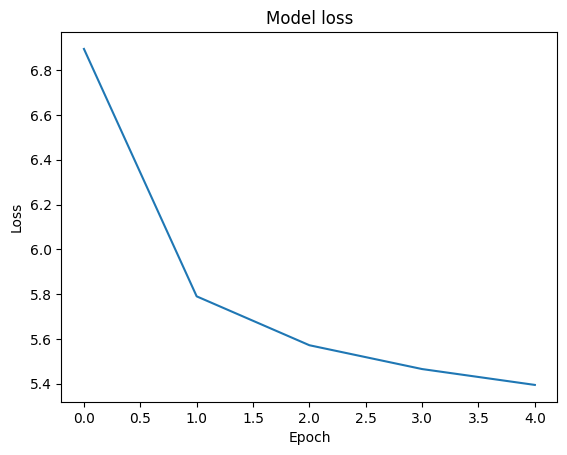

In [ ]:

plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

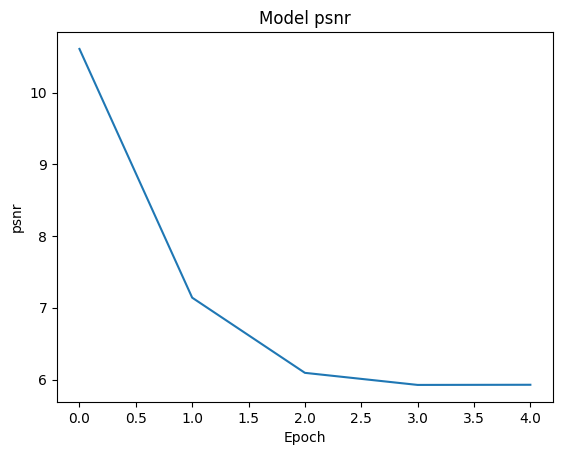

In [ ]:

plt.plot(psnr_history)
plt.title('Model psnr')
plt.ylabel('psnr')
plt.xlabel('Epoch')
plt.show()

In [ ]:

autoencoder_model.save_weights('/content/drive/MyDrive/weights1.weights.h5')

In [ ]:

autoencoder_model.load_weights('/content/drive/MyDrive/weights1.weights.h5')

## Results

In [ ]:
decoded = autoencoder_model.predict([input_S, input_C])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C)

16/16 ━━━━━━━━━━━━━━━━━━━━ 441s 27s/step


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.metrics import peak_signal_noise_ratio as psnr

SHOW_GRAY = False
SHOW_DIFF = True
ENHANCE = 1
n = 200
SAVE_PATH = "/content/drive/MyDrive/finalSten"
os.makedirs(SAVE_PATH, exist_ok=True)


def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_and_save_image(imgs, titles, index):
    plt.figure(figsize=(14, 4))
    n_col = len(imgs)
    for i, (img, title) in enumerate(zip(imgs, titles)):
        ax = plt.subplot(1, n_col, i + 1)
        if SHOW_GRAY:
            plt.imshow(rgb2gray(img), cmap='gray')
        else:
            plt.imshow(img)
        ax.axis('off')
        plt.title(title)

    save_filename = os.path.join(SAVE_PATH, f"result_{index}.png")
    plt.savefig(save_filename, bbox_inches='tight')
    plt.close()

def process_images():

    num_samples = len(input_C)
    rand_indx = [random.randint(0, num_samples - 1) for _ in range(n)]

    for i, idx in enumerate(rand_indx):
        images = [input_C[idx], input_S[idx]]
        titles = ['Cover', 'Secret']

        if SHOW_DIFF:
            constructed_cover = np.multiply(diff_C[idx], ENHANCE)
            constructed_secret = np.multiply(diff_S[idx], ENHANCE)
            images.extend([constructed_cover, constructed_secret])
            titles.extend(['Constructed Cover', 'Constructed Secret'])

            psnr_values.append(psnr(input_C[idx], constructed_cover))



        show_and_save_image(images, titles, i)

    avg_psnr = np.mean(psnr_values)


    print(f"Average PSNR: {avg_psnr:.2f}")

process_images()

Average PSNR: 25.95
